# Modelling 3D Gas/Liquid Expansion

Graham Thoms and Andrew Wighton

In [23]:
from __future__ import print_function, division
from random import randint 
from itertools import chain
from Cell2D import Cell2D, Cell2DViewer
from scipy.signal import correlate2d
%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import thinkplot
from tqdm import tqdm_notebook

from matplotlib import rc
rc('animation', html='html5')

## 2-D Gas expansion

To understand the complex nature of 3D gas expansion in a cavern, first the development of a 2 dimensional simulation was needed.

In [56]:
class RDViewer(Cell2DViewer):
    """Generates images and animations."""
    
    cmapv = plt.get_cmap('Greys')
    cmapu = plt.get_cmap('Blues')
    
    options = dict(alpha=.5,
                   interpolation='none', 
                   vmin=0, vmax=5)


    def __init__(self, viewee):
        """Initializes the attributes.
        
        viewee: the object to be represented
        """
        self.viewee = viewee
        self.imu = None
        self.imv = None
        self.hlines = None
        self.vlines = None

    def draw(self, grid=False):
        """Draws the cells."""
        au = self.viewee.array.copy()
        av = self.viewee.array2.copy()
        
        n, m = av.shape
        plt.axis([0, m, 0, n])
        plt.xticks([])
        plt.yticks([])

        self.options['extent'] = [0, m, 0, n]
        self.imu = plt.imshow(au, cmap=self.cmapu, **self.options)
        self.imv = plt.imshow(av, cmap=self.cmapv, **self.options)

    def animate_func(self, i):
        """Draws one frame of the animation."""
        if i > 0:
            self.step(iters=1)

        self.imu.set_array(self.viewee.array)
        self.imv.set_array(self.viewee.array2)
        return (self.imu, self.imv)

2 dimentsional gas expansion algorithm

In [163]:
from Cell2D import Cell2D, Cell2DViewer
from scipy.signal import correlate2d
class Percolation(Cell2D):
    """Percolation Cellular Automaton."""

    kernel = np.array([[0, 1, 0],
                       [1, -4, 1],
                       [0, 1, 0]])

    options = dict(mode='same', boundary='wrap')
    def __init__(self, n, m=None, p=0.5, r=0.1, seed = 22, mode='random'):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        p: probability of porousness
        r: diffusion rate constant
        """
        self.r = r
        self.p = p
        m = n if m is None else m
        if seed is not None:
            np.random.seed(seed)
        # fill random areas with inpermiable materials
        self.array2 = np.random.choice([0.0,5.0], (n, m), p=[1-p, p])
        # fill remaining areas with permiable materials/caverns
        self.array = np.zeros((n, m), np.float)
        #randomly place gas cells
        if(mode == 'random'):
            self.array = np.random.choice([0.0,5.0], (n, m), p=[1-(p/100), (p/100)])
        #fill center with gas cells
        if(mode == 'center'):
            self.array[n/2, m/2] = 5
    def step(self):
        """Executes one time step."""
        a = self.array
        a2 = self.array2
        c = correlate2d(a, self.kernel, mode='same', boundary='fill')
        c2 = correlate2d(a2, self.kernel, mode='same', boundary= 'fill')

        self.array[((a==0) & (c>=5)) & (a2==0)] =  5
        self.array +=  self.r * c

The gas expnasion percolation model simulation is shown below. The gas starts at random locations and through each step expands through the cells.

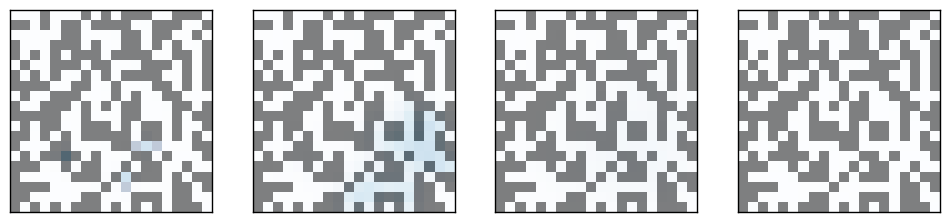

In [165]:
seed = 22
perc = Percolation(20, p=0.5,seed = 22,mode = 'random')
viewer = RDViewer(perc)

thinkplot.preplot(cols=4)
viewer.step()
viewer.draw()

thinkplot.subplot(2)
viewer.step(10)
viewer.draw()

thinkplot.subplot(3)
viewer.step(100)
viewer.draw()

thinkplot.subplot(4)
viewer.step(1000)
viewer.draw()

And the resulting animation

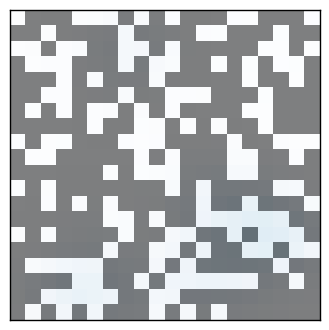

In [167]:
perc = Percolation(20, p=0.6, mode = 'random')
viewer = RDViewer(perc)
anim = viewer.animate(frames=20)
anim

## 3-D Gas Expansion

The following class will build a 3D permiable space (probability p). This code is based off Alan Downey's code for percolation of a 2D space. Essentially the 2D space is extended into a third direction 'z', creating multiple 2D permiable spaces (referred to as layers), that are stacked on top of eachother, which allows each layer to interact with adjacent layers.

In [196]:
class Percolation3D(Percolation):
    
    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])
    
    layers = []
    fade = True
    
    def __init__(self, n, m=None, z=None, p=0.5, r=0.1, seed=None, mode='center', fade=True):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        z: number of layers
        p: probability of porousness
        r: rate of diffusion
        mode: changes placement of gas eg 4 options; top, center, outside, random
        fade: should wet cells fade every step
        """
        self.p = p
        self.r = r
        self.cnt = 0
        self.fade = fade
        m = n if m is None else m
        z = n if z is None else z
        if seed is not None:
            np.random.seed(seed)
        
        # create array of 2D porous layers which make up the 3D porous space
        self.layers = [np.random.choice([0.0, 1.0], (n, m), p=[1-p, p]) for x in range(z)]
        
        #fill center cell of top layer
        if (mode =='top'):
            self.layers[0][n//2,m//2] = 5
        #fill center cell of center layer    
        if(mode =='center'):
            self.layers[z//2][n//2,m//2] = 5
        #fill center cell of top and bottom layers     
        if(mode == 'outside'):
            self.layers[0][n//2,m//2] = 5
            self.layers[z-1][n//2,m//2] = 5
        #fill random cell of every layer     
        if(mode == 'random'):
            for i in range(z):
                x = np.random.randint(n)
                y = np.random.randint(m)
                self.layers[i][x,y] = 5
            
    def step(self):
        """Executes one time step."""

        num_layers = len(self.layers)
        
        # if a cell will get wet, set it's level of wetness
        # to be inversely proportional to the number of steps already taken
        blk_diff = 5-self.r*self.cnt if 5-self.r*self.cnt > 1 else 1.1
    
        # expand gaseous cells to porous cells for individual layers
        for l in range(num_layers):
            a = self.layers[l]
            c = correlate2d(a, self.kernel, mode='same')
            self.layers[l][(a==1) & (c>4)] = blk_diff
            
    
        # for each layer fill the porous cells with gas
        # if cells of the adjacent layers have gas in them
        for l in range(num_layers):
            
            # array that will indicate the adjacent gaseous cells of a layer
            adj_wet_cells = np.zeros((len(self.layers[0][0]),len(self.layers[0])),dtype=np.float);
            
            left = l-1
            right = l+1
            
            # check left layer
            if left >= 0:
                adj_wet_cells[self.layers[left] > 1] = blk_diff
            
            # check right layer
            if right < num_layers:
                adj_wet_cells[self.layers[right] > 1] = blk_diff
    
            a = self.layers[l]

            # fill the porous cells of the current layer
            # if the adjacent cells are wet
            self.layers[l][(a==1) & (adj_wet_cells > 1)]= blk_diff
            
        self.cnt += 1
        
        if self.fade:
            self.diff_layers()
        
 
    def diff_layers(self):
        """DIffuse each gaseous cell each step"""
        num_layers = len(self.layers)
        
        for l in range(num_layers):
            a = self.layers[l]
            self.layers[l][(a>1)] -= self.r
    
    def num_gas(self):
        """Total number of wet cells.
        """
        return np.sum([self.num_gas_layer(x) for x in range(len(self.layers))])

    def num_gas_layer(self, layer):
        """ Total number of wet cells in layer
        layer: layer index
        """
        return np.sum(self.layers[layer] > 1)
    
    def top_layer_gas(self):
        """Returns: number of gaseous cells in top layer"""
        return self.num_gas_layer(0)
    
    def bottom_layer_gas(self):
        """Returns: number of gaseous cells in bottom layer"""
        return self.num_gas_layer(-1)
        
    def run(self, num_steps=100, normalized=False):
        """ Run model for num_steps
        return: array of total number of gaseous cells per step
        """
        num_gas_array = []
        for x in range(num_steps):
            num_gas_array.append(self.num_gas())
            self.step()
        return num_gas_array/max(num_gas_array) if normalized else num_gas_array

The following is a viewer for visualizing the 3D percolation model

In [169]:
class PercolationViewer3D(Cell2DViewer):
    """Draws and animates a 3D Percolation object."""
    cmap = plt.get_cmap('Blues')
    options = dict(alpha=0.6,
                   interpolation='none', 
                   vmin=0, vmax=5)
    
    view_layers = []
    draw_title=True
    
    def __init__(self, perc3d):
        Cell2DViewer.__init__(self, perc3d)
        self.perc = perc3d
            
    
    def draw(self):
        z = len(self.perc.layers)
        
        cols = 5
        rows = np.ceil(z/cols)        
        
        thinkplot.preplot(cols=cols, rows=rows)
        for x in range(z):
            thinkplot.subplot(x+1)
            if self.draw_title:
                thinkplot.config(title='{0} {1}'.format('Layer', str(x+1)))
            self.perc.array = self.perc.layers[x]
            Cell2DViewer.draw(self)

    def animate(self, frames=20, interval=200, draw_title=True):
        """Creates an animation.

        frames: number of frames to draw
        interval: time between frames in ms
        draw_title: draw title for each layer
        """
        self.draw_title=draw_title
        fig = plt.figure()
        self.draw()
        anim = animation.FuncAnimation(fig, self.animate_func,
                                       init_func=self.init_func,
                                       frames=frames, interval=interval)
        return anim

    def init_func(self):
        """Called at the beginning of an animation."""
        pass
    
    def animate_func(self,i):
        if i > 0:
            self.step()
            self.draw()
        

The following will show the percolation of a single gaseous cell on the top layer through each layer below.

The 3D space consists of 5 10x10 permiable layers (p=0.41), with a diffusion rate of 0.1.

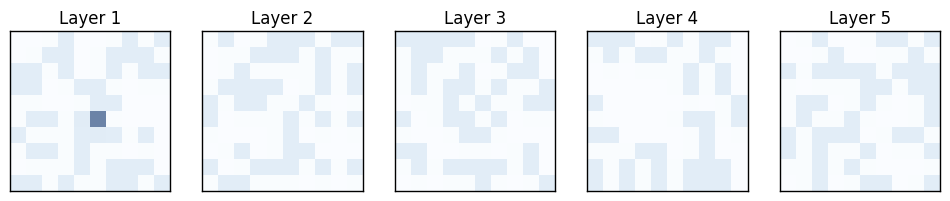

In [189]:
seed = 22
perc = Percolation3D(10,z=5,r=0.1,p=0.41, mode='top',seed=seed)
viewer = PercolationViewer3D(perc)
viewer.draw()

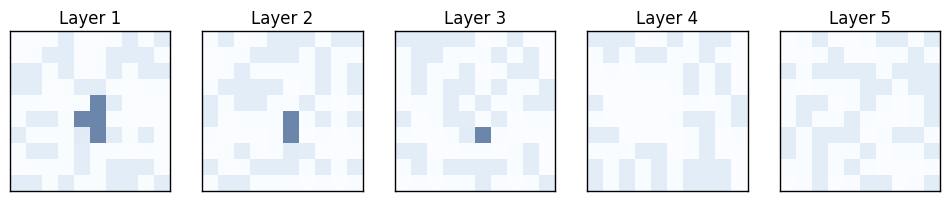

In [190]:
viewer.step()
viewer.draw()

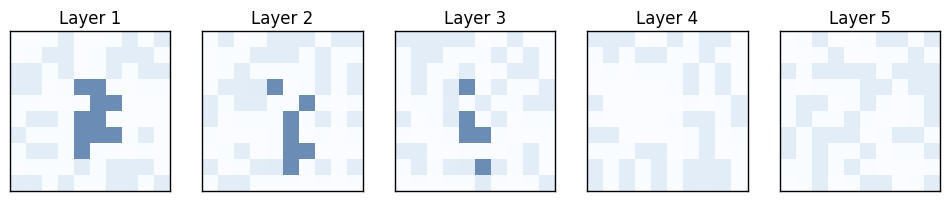

In [191]:
viewer.step(2)
viewer.draw()

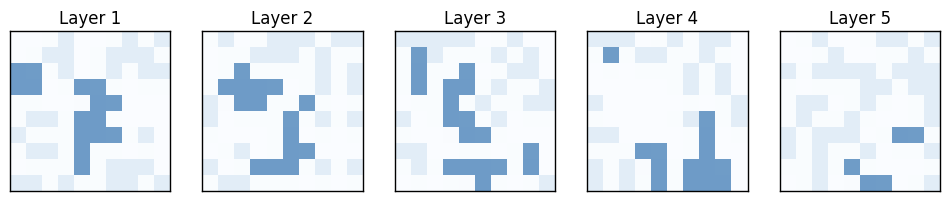

In [192]:
viewer.step(5)
viewer.draw()

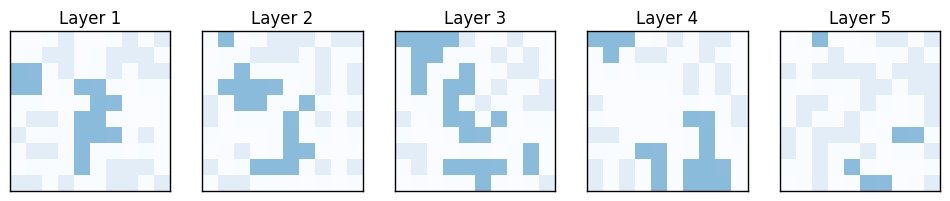

In [193]:
viewer.step(10)
viewer.draw()

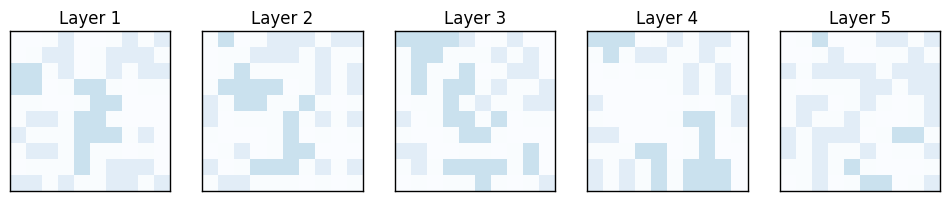

In [194]:
viewer.step(15)
viewer.draw()

Animates the 3D percolation of 10 layers of 10x10 cells, diffusion rate of 0.1, permiable probability 0.41, with one gaseous cell on the top layer.

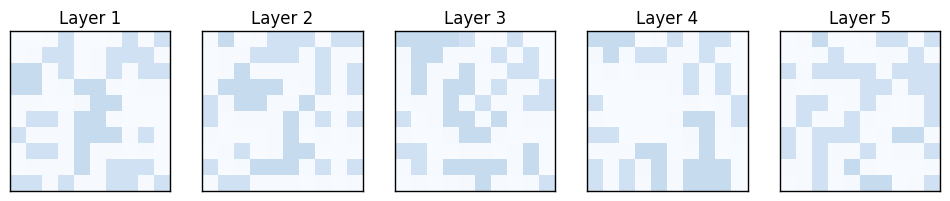

In [195]:
seed = 22
perc3d = Percolation3D(10,z=5,r=0.1,p=0.41, mode='top',seed=seed)
viewer = PercolationViewer3D(perc3d)
anim = viewer.animate(frames=40, draw_title=True)
anim

The following function will test the probability of a permiable cell on the bottom layer becoming gaseous, if the top layer starts out with one gaseous cell.

In [229]:
def estimate_prob_percolating3D(n=10, z=10, r=0.5, p=0.5, mode='top', iters=100):
    """Estimates the probability of percolating 
    
    from top layer to bottom layer
    
    or
    
    from center to top or bottom layer
    
    
    n: int number of rows and columns
    z: int number of layers
    r: diffusion constant
    p: probability that a cell is permeable
    mode: test top to bottom or from center outwards
    iters: number of arrays to test
    
    returns: float probability
    """
    count = 0

    if mode == 'top':
        for i in range(iters):
            perc = Percolation3D(n=n,z=z,r=r,p=p,mode='top',fade=False)  
            perc.run()
            if perc.bottom_layer_gas() > 0:
                count += 1
                
    elif mode == 'center':
        for i in range(iters):
            perc = Percolation3D(n=n,z=z,r=r,p=p,mode='center',fade=False)  
            perc.run()
            if perc.bottom_layer_gas() > 0 or perc.top_layer_gas() > 0:
                count += 1
        
    return count / iters

For a 20 layer permiable space (p=0.5, r=0.5, n=10), the probability of gaseous cells percolating from the top layer to the bottom layer is around 12 percent

In [159]:
%time fraction = estimate_prob_percolating3D(n=10, z=20)
print(fraction)

Wall time: 11.4 s
0.12


And from the center to the top or bottom layer is 93 percent

In [200]:
%time fraction = estimate_prob_percolating3D(n=10, z=20, mode='center')
print(fraction)

Wall time: 11.7 s
0.93


We can compare the probability of percolation from the top layer to the bottom layer for different number of layers with test_perc_prob_z()

In [160]:
def test_perc_prob_z(num_layers=1):
    """Display a graph of percolating probabilities
    for 1 <= z <= num_layers
    
    num_layers = number of layers to test
    """
    perc_prob = []
    
    xs = np.linspace(0,num_layers-1,num_layers)
    
    for i in tqdm_notebook(range(num_layers)):
        perc_prob.append(estimate_prob_percolating3D(n=10, z=i+1))
            
    thinkplot.plot(perc_prob,style='.', label="Probability")
    p3 = np.poly1d(np.polyfit(xs, perc_prob, 4))
    thinkplot.plot(xs,p3(xs), label="Line of Best Fit")
    thinkplot.config(xlabel='Number of Layers',
                    ylabel='Probability of Wet Bottom Layer',
                    xscale='linear', xlim=[1, num_layers], 
                    yscale='linear', ylim=[0, 1],
                    title='Prob Wet Bottom Layer vs. # of Layers',
                    loc='top left')


test_perc_prob() can take some time, for testing 1 to 30 layers it will take roughly 5 mins depending on your machine.


Wall time: 4min 35s


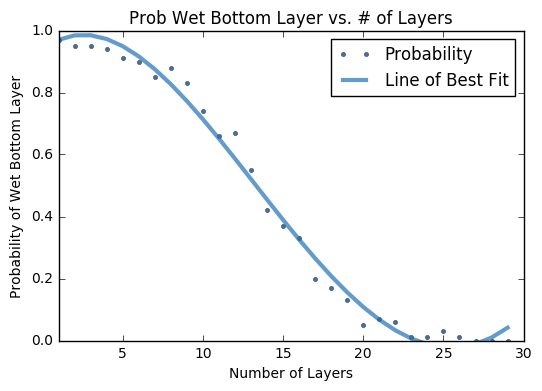

In [161]:
%time test_perc_prob_z(num_layers=30)

We can see that the decrease in probability is linear between the number of layers 7 and 17. The probability drops off quicker from 0 to 6, and slower from 18 to 30.

Furthermore, we can compute the probability of gas/liquid transferring from top to bottom layer, depending on the permiability of the layers.

In [252]:
def test_perc_prob_p(num_intervals=1):
    """Display a graph of percolating probabilities
    for 0 <= p <= 1.0
    
    intervals: number of intervals between 0 and 1 to test
    """
    perc_prob = []
    
    xs = np.linspace(0,1,num_intervals)
    
    for i in tqdm_notebook(range(num_intervals)):
        perc_prob.append(estimate_prob_percolating3D(n=10, z=5, p=xs[i]))
            
    thinkplot.plot(xs, perc_prob, style='.', label="Probability")
    thinkplot.config(xlabel='Probability of Porousness of a Layer',
                    ylabel='Probability of Wet Bottom Layer',
                    xscale='linear', xlim=[0, 1], 
                    yscale='linear', ylim=[0, 1],
                    title='Prob Wet Bottom Layer vs. Porourness of Layer',
                    loc='top left')

this test with 50 intervals between 0 and 1 will take roughly 3 mins


Wall time: 2min 41s


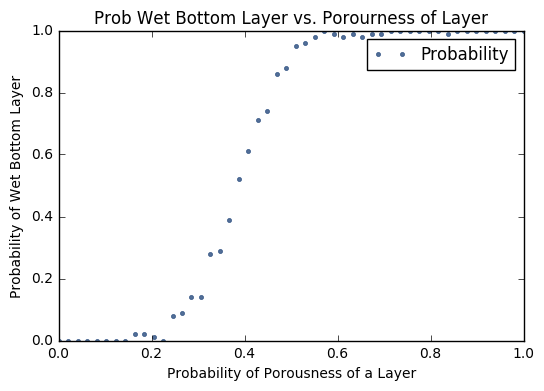

In [253]:
%time test_perc_prob_p(num_intervals=50)

It can be seen in the above graph that the probability of gas/liquid at the top layer percolating down to the bottom layer increases dramatically between 0.3 and 0.5 probability of porousness.